# Lineare Regressionsanalyse auf Kennzahl Flüchtlingsanteil pro 1000 Einwohnern

Um Länder mit unterschiedlich grosser Bevölkerung besser vergleichen zu können, haben wir die absoluten Flüchtlingszahlen mit den jeweiligen Einwohnerzahlen kombiniert. Daraus wurde für jedes Land und jedes Jahr der Flüchtlingsanteil pro 1.000 Einwohner berechnet. Diese Kennzahl wurde getrennt für Herkunfts und Zielländer betrachtet.

Der Flüchtlingsanteil pro 1.000 Einwohner dient im Folgenden als abhängige Variable. Durch diese Normierung lassen sich zeitliche Entwicklungen vergleichen, ohne dass Unterschiede in der Bevölkerungsgrösse das Ergebnis verzerren.

Ein Ziel dieser Aufbereitung war es ausserdem, die Daten für eine lineare Regressionsanalyse nutzbar zu machen. In diesem Notebook wird deshalb für ausgewählte Länder ein einfaches lineares Regressionsmodell (OLS) geschätzt, in dem der Flüchtlingsanteil als Funktion der Zeit modelliert wird. Die Regression wird dabei vor allem zur Beschreibung langfristiger Trends verwendet und nicht zur kausalen Interpretation.

Die Ergebnisse werden sowohl grafisch dargestellt als auch anhand zentraler Regressionskennzahlen diskutiert. Zusätzlich werden Diagnoseplots verwendet, um zu prüfen, inwieweit die Annahmen des linearen Modells erfüllt sind und wie aussagekräftig die Ergebnisse eingeschätzt werden können.

# Import Setup

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.stats.outliers_influence import OLSInfluence


In [2]:

def plot_and_forecast_country_de(df, country, forecast_years=5, figsize=(10, 6)):
   

   
    # Daten nach dem augewählten Land filtern und chronologisch sortieren
    sub = df[df["country"] == country].dropna().copy()
    sub = sub.sort_values("Year")

    
    # Zeitvariable zentrieren
    year_mean = sub["Year"].mean()
    sub["year_c"] = sub["Year"] - year_mean


    # OLS Modell schaetzen
    y = sub["share_per_1000"]
    X = sm.add_constant(sub["year_c"])

    model = sm.OLS(y, X).fit()

    
    # lineare Prognose auf Basis des geschätzen Modells
    last_year = sub["Year"].max()
    future_years = np.arange(last_year + 1, last_year + 1 + forecast_years)

    future_years_c = future_years - year_mean
    X_future = sm.add_constant(future_years_c)
    preds = model.get_prediction(X_future)
    pred_summary = preds.summary_frame(alpha=0.05)

    forecast_df = pd.DataFrame({
        "Jahr": future_years,
        "Prognose_share_per_1000": pred_summary["mean"],
        "Unteres_95KI": pred_summary["mean_ci_lower"],
        "Oberes_95KI": pred_summary["mean_ci_upper"]
    })

    
    # Plot
    plt.figure(figsize=figsize)

    # Beobachtungswerte
    plt.plot(
        sub["Year"], sub["share_per_1000"],
        marker="o", label="Beobachtungswerte"
    )

    # Prognose
    plt.plot(
        future_years, pred_summary["mean"],
        linestyle="--", color="red", label="Prognose"
    )

    # 95%-Konfidenzintervall
    plt.fill_between(
        future_years,
        pred_summary["mean_ci_lower"],
        pred_summary["mean_ci_upper"],
        color="red", alpha=0.2,
        label="95%-Konfidenzintervall"
    )

    
    # Anzeige der wichtigsten Regressionskennzahlen
    beta = model.params["year_c"]
    se = model.bse["year_c"]
    tval = model.tvalues["year_c"]
    pval = model.pvalues["year_c"]
    r2 = model.rsquared

    stats_text = (
        f"β = {beta:.3f}\n"
        f"Standardfehler = {se:.3f}\n"
        f"t-Wert = {tval:.3f}\n"
        f"p-Wert = {pval:.3g}\n"
        f"R² = {r2:.3f}"
    )

    
    plt.text(
        0.98, 0.60, stats_text,
        transform=plt.gca().transAxes,
        fontsize=10,
        ha="right",
        va="top",
        bbox=dict(facecolor="white", alpha=0.85)
    )

    
    # Achsenbeschriftung und Titel 
    plt.xlabel("Jahr")
    plt.ylabel("Flüchtlingsanteil pro 1000 Einwohner")
    plt.title(f"Entwicklung des Flüchtlingsanteils in {country} und lineare Prognose (OLS)")

    plt.grid(True)
    plt.legend(loc="upper right")  
    plt.tight_layout()
    plt.show()

    return model, forecast_df, model.summary().as_text()

In [3]:

def diagnose_plots(model,country_name, figsize=(18, 5)):
   
    residuals = model.resid
    fitted = model.fittedvalues


    # Diagnoseplots erstellen
    fig, axes = plt.subplots(1, 3, figsize=figsize)

    
    # 1. Residuals vs Fitted 
    axes[0].scatter(fitted, residuals)
    axes[0].axhline(0, color="red", linestyle="--")

    axes[0].set_title(f"Residuals vs Fitted – {country_name}")
    axes[0].set_xlabel("Vorhergesagte Werte (Fitted Values)")
    axes[0].set_ylabel("Residuen")

    
    # 2. QQ-Plot 
    sm.qqplot(residuals, line="45", ax=axes[1])
    axes[1].set_title("QQ-Plot der Residuen")
    axes[1].set_xlabel("Theoretische Normal-Quantile")
    axes[1].set_ylabel("Beobachtete Quantile der Residuen")

    
    # 3. Cook's Distance 
    influence = OLSInfluence(model)
    cooks = influence.cooks_distance[0]

    axes[2].stem(np.arange(len(cooks)), cooks, basefmt=" ")
    axes[2].axhline(4/len(cooks), color="red", linestyle="--")
    axes[2].text(0, 4/len(cooks) + 0.005,
                 f"Faustregel 4/n ≈ {4/len(cooks):.2f}",
                 color="red")

    axes[2].set_title("Cook's Distance")
    axes[2].set_xlabel("Beobachtung (Index)")
    axes[2].set_ylabel("Cook's Distance")

    plt.tight_layout()
    plt.show()

    


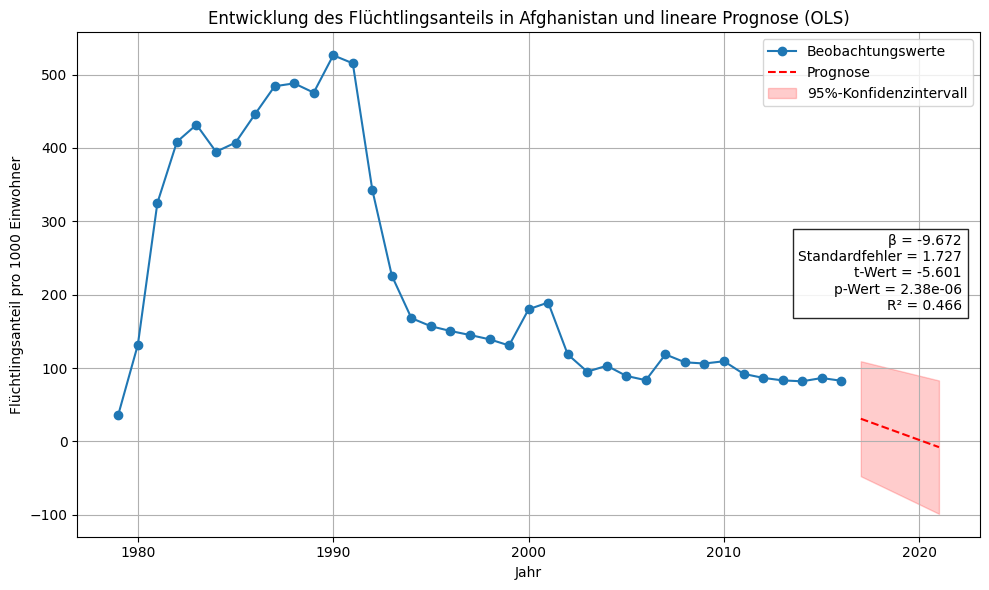

                            OLS Regression Results                            
Dep. Variable:         share_per_1000   R-squared:                       0.466
Model:                            OLS   Adj. R-squared:                  0.451
Method:                 Least Squares   F-statistic:                     31.37
Date:                Tue, 06 Jan 2026   Prob (F-statistic):           2.38e-06
Time:                        21:48:29   Log-Likelihood:                -233.77
No. Observations:                  38   AIC:                             471.5
Df Residuals:                      36   BIC:                             474.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        219.5825     18.938     11.595      0.0

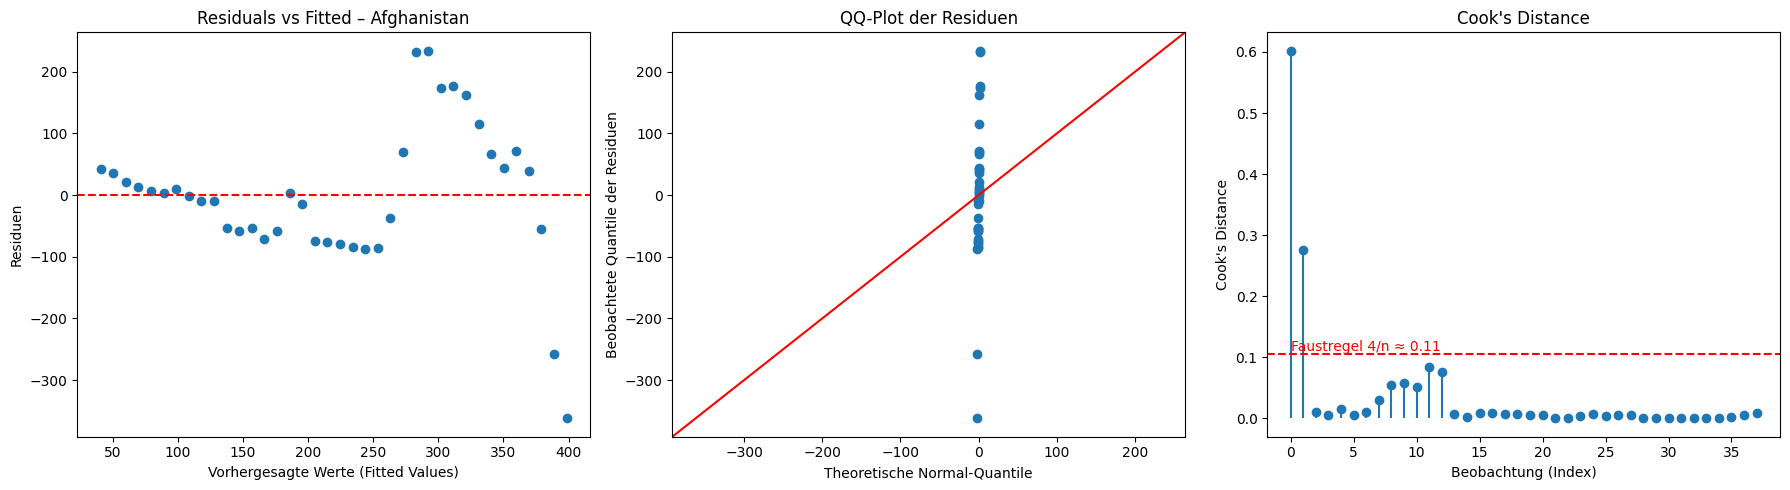

In [4]:
df = pd.read_csv("output_csv_files/Origin_refugees_per_capita.csv")

model, forecast, summary = plot_and_forecast_country_de(
    df,
    country="Afghanistan",
    forecast_years=5
)

print(summary)
print(forecast)


diagnose_plots(model, "Afghanistan")


# Interpretation der linearen Regression für den Flüchtlingsanteil (pro 1000 Einwohnern) die aus Afghanistan geflohen sind


### 1. Regressionskennzahlen

- Der geschätzte Beta-Koeffizient ist negativ und weist auf einen langfristigen abwärtsgerichteten Trend des Flüchtlingsanteils pro 1.000 Einwohner im Zeitverlauf hin.
- Der p-Wert ist sehr klein, sodass der geschätzte Trend statistisch signifikant ist.
- Der Standardfehler des Koeffizienten ist im Verhältnis zur geschätzten Steigung relativ klein, was auf eine präzise Schätzung hindeutet.
- Das Bestimmtheitsmass R² von 0,46 ist für stark schwankende sozialwissenschaftliche Zeitreihendaten ein respektabler Wert.


### 2. Residuals vs Fitted

- Im Residuals-vs-Fitted-Plot sind klare Muster in den Residuen erkennbar.
- Dies deutet auf einen nichtlinearen Zusammenhang zwischen Zeit und Flüchtlingsanteil sowie auf eine nicht konstante Fehlervarianz (Heteroskedastizität) hin.


### 3. QQ-Plot der Residuen

- Der QQ-Plot zeigt deutliche Abweichungen von der Diagonalen.
- Die Residuen sind somit nicht normalverteilt.
- Dadurch sind die Voraussetzungen für eine korrekte Berechnung von t-Werten, p-Werten und Konfidenzintervallen nur eingeschränkt erfüllt.


### 4. Cook’s Distance

- Der Cook’s-Distance-Plot zeigt einzelne Beobachtungen mit starkem Einfluss auf die Regressionsschätzung.$
- Die Lage der Regressionsgeraden wird somit überproportional von einzelnen Jahren bestimmt.


### 5. Konklusion

Obwohl das Modell statistisch signifikante Ergebnisse liefert, ist es inhaltlich nur eingeschränkt geeignet, um den tatsächlichen zeitlichen Verlauf abzubilden oder belastbare Prognosen zu erstellen.

Das lineare Regressionsmodell eignet sich daher primär zur deskriptiven Darstellung eines groben Trends, nicht jedoch zur detaillierten Modellierung der komplexen und nichtlinearen Dynamik der Flüchtlingsentwicklung.

count    57.000000
mean      6.614295
std       5.118941
min       1.069254
25%       1.583548
50%       7.049626
75%      10.272805
max      17.472444
Name: share_per_1000, dtype: float64
9
###### 66
57
240239.9477982754


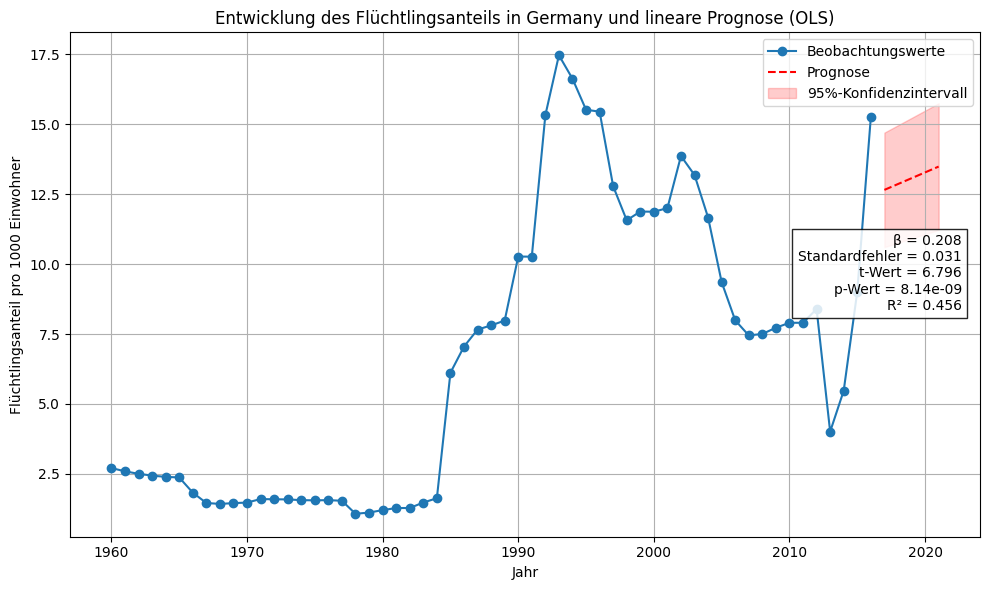

                            OLS Regression Results                            
Dep. Variable:         share_per_1000   R-squared:                       0.456
Model:                            OLS   Adj. R-squared:                  0.447
Method:                 Least Squares   F-statistic:                     46.18
Date:                Tue, 06 Jan 2026   Prob (F-statistic):           8.14e-09
Time:                        21:48:30   Log-Likelihood:                -156.08
No. Observations:                  57   AIC:                             316.2
Df Residuals:                      55   BIC:                             320.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.6143      0.504     13.113      0.0

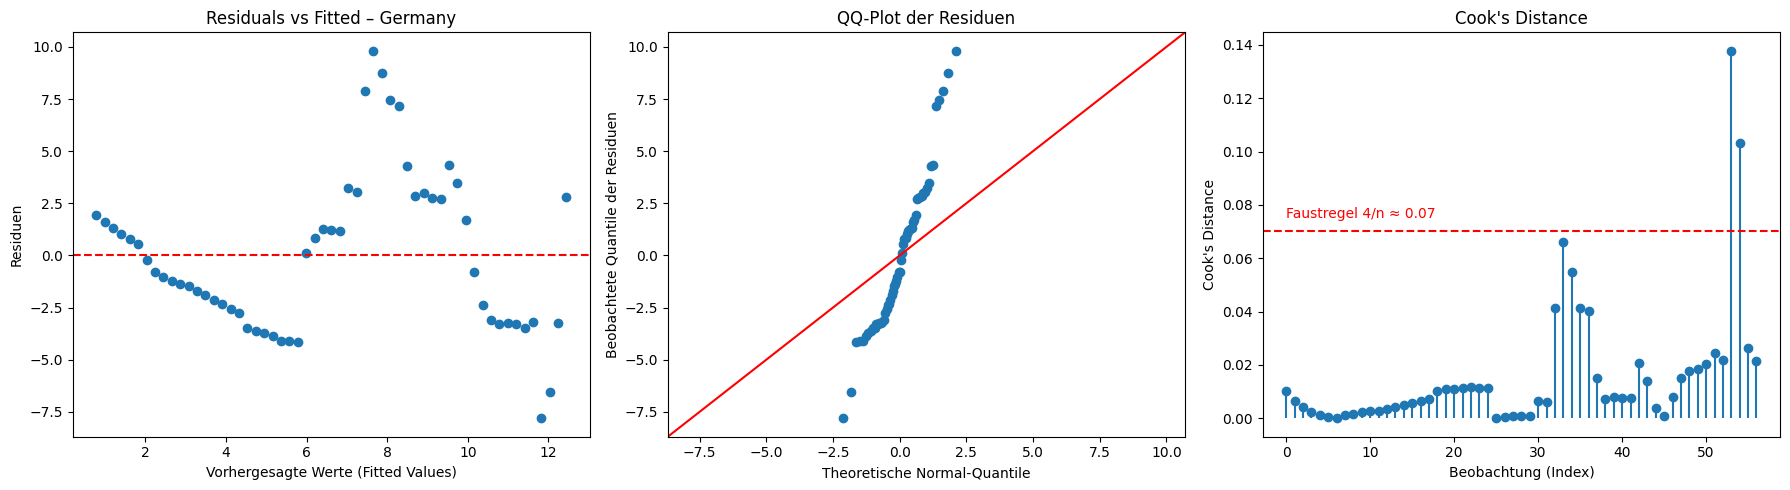

In [5]:
df = pd.read_csv("output_csv_files/Destination_refugees_per_capita.csv")
sub = df[df["country"] == "Germany"]
print(sub["share_per_1000"].describe())
print(sub["share_per_1000"].isna().sum())
print("######",sub["Year"].nunique())

sub_clean = sub[["Year", "share_per_1000"]].dropna()
print(len(sub_clean))
print(np.linalg.cond(sm.add_constant(sub_clean["Year"])))

model, forecast, summary = plot_and_forecast_country_de(
    df,
    country="Germany",
    forecast_years=5
)

print(summary)
print(forecast)


diagnose_plots(model, "Germany")


# Interpretation der linearen Regression für den Flüchtlingsanteil (pro 1000 Einwohnern), die nach Deutschland geflohen sind

### 1.) Regressionskennzahlen

- Der geschätzte Beta Koeffizient ist positiv und zeigt einen langfristigen aufwärtsgerichteten Trend des Flüchtlingsanteils pro 1.000 Einwohner in Deutschland.
- Die Steigung von rund 0,21 bedeutet, dass der lineare Trend einen durchschnittlichen jährlichen Anstieg des Flüchtlingsanteils anzeigt.
- Der sehr kleine p Wert zeigt, dass dieser Trend statistisch signifikant ist.
- Mit einem R² von 0,46 erklärt das Modell einen moderaten Anteil der zeitlichen Variation, was für stark schwankende sozialwissenschaftliche Zeitreihendaten als akzeptabel gilt.

### 2.) Diagnoseplots

- Die Diagnoseplots zeigen ein ähnliches Muster wie bei der Analyse Afghanistans.
- Insbesondere deuten systematische Residuenmuster und Abweichungen von der Normalverteilung darauf hin, dass zentrale Annahmen des linearen Regressionsmodells verletzt sind.

### 3.) Konklusion

Obwohl der geschätzte Trend statistisch signifikant ist, ist das lineare Regressionsmodell auch für Deutschland nur eingeschränkt geeignet.

Der Verlauf der Daten ist stark nichtlinear und durch einzelne Jahre geprägt, sodass das Modell vor allem zur deskriptiven Darstellung eines groben Trends dient, nicht jedoch für eine realistische Abbildung des zeitlichen Verlaufs oder für belastbare Prognosen.